In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random

import IPython.display as ipd
import librosa
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch

import promonet

/home/mrm5248/micromamba/envs/promonet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [56]:
def plot_formants(audio):
    plt.figure(figsize=(12, 12))

    # Compute pitch and periodicity
    pitch, periodicity = promonet.preprocess.from_audio(
        audio,
        gpu=0,
        features=['pitch', 'periodicity'])
    pitch, periodicity = pitch.cpu(), periodicity.cpu()

    # Compute formants
    formants = promonet.formants.from_audio(
        audio,
        promonet.SAMPLE_RATE,
        features='stft',
        decoder='viterbi',
        max_formants=6)
    
    # Compute STFT
    features, frequencies = promonet.formants.stft(
        audio,
        promonet.SAMPLE_RATE)
    features, frequencies = features.numpy(), frequencies.numpy()
    
    # Compute frame times
    times = np.linspace(
        0,
        promonet.convert.samples_to_seconds(audio.shape[-1]),
        features.shape[0])
    
    # Plot STFT
    plt.pcolormesh(times, frequencies, features[:-1, :-1].T)
    plt.yscale('symlog')
    
    # Overlay pitch
    unvoiced = periodicity[0] < promonet.VOICING_THRESHOLD
    x = torch.clone(pitch).squeeze()
    x[unvoiced] = float('nan')
    plt.plot(times, x, linewidth=2, color='black', label='Pitch')
    
    # Overlay formants
    colors = ['orange', 'green', 'red', 'gray', 'yellow', 'teal']
    for i, formant in enumerate(formants):
        x = torch.clone(formant)
        x[unvoiced] = float('nan')
        plt.plot(
            times,
            x,
            linewidth=2,
            color=colors[i],
            linestyle='--',
            label=f'F{i}')

    ipd.display(ipd.Audio(audio, rate=promonet.SAMPLE_RATE))

In [57]:
dataset = 'vctk'
stems = promonet.load.partition(dataset)['train']
stem = random.choice(stems)
file = promonet.CACHE_DIR / dataset / f'{stem}-100.wav'
audio = promonet.load.audio(file)

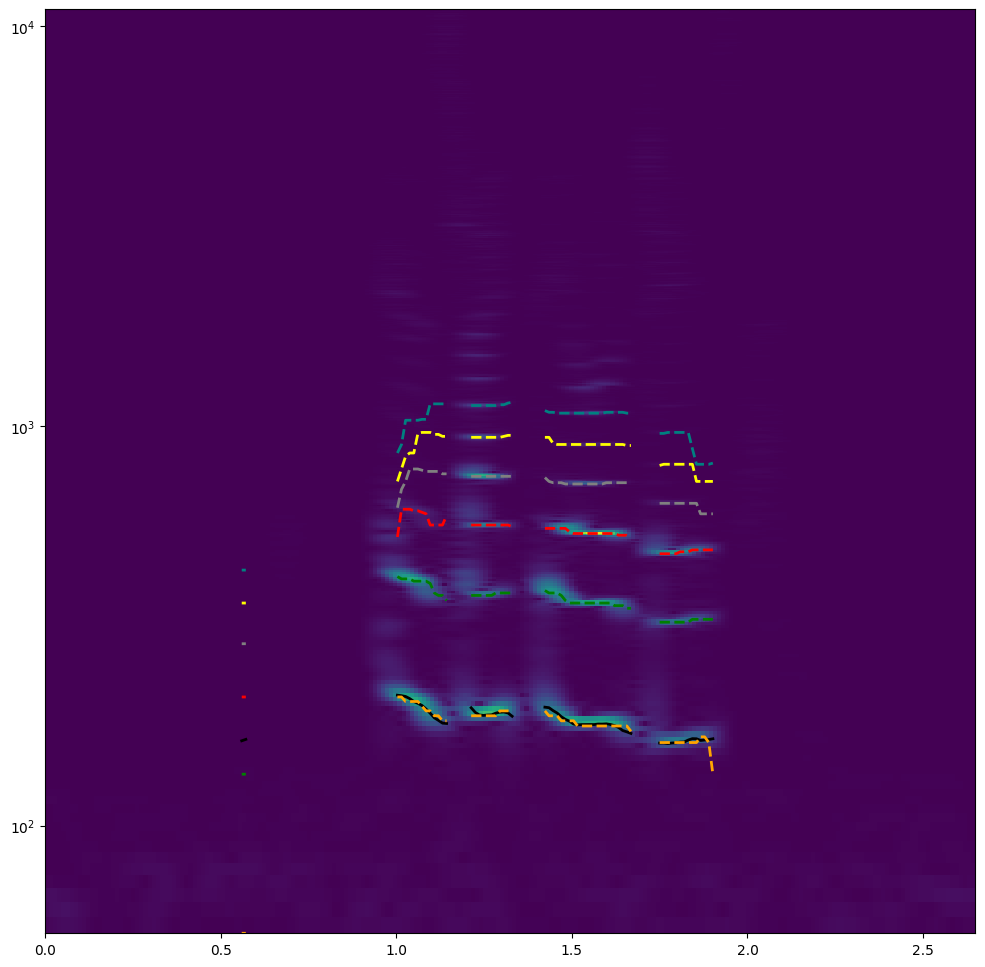

In [58]:
plot_formants(audio)

In [59]:
# Compute pitch and periodicity
pitch, periodicity = promonet.preprocess.from_audio(
    audio,
    gpu=0,
    features=['pitch', 'periodicity'])
pitch, periodicity = pitch.cpu().to(torch.float32), periodicity.cpu().to(torch.float32)

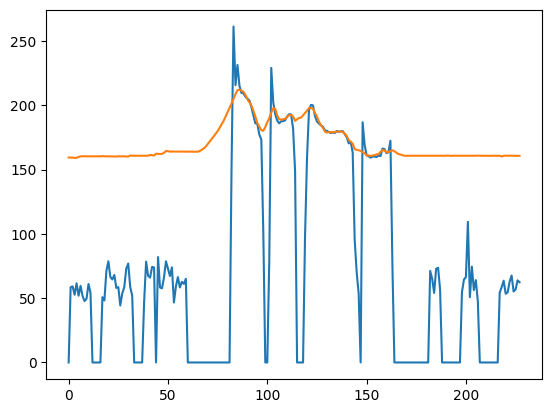

In [61]:
world_pitch, spectrogram, aperiodicity = promonet.baseline.world.analyze(
    audio.numpy().squeeze(),
    promonet.convert.samples_to_frames(audio.shape[-1]))
plt.plot(world_pitch)
plt.plot(pitch.squeeze())

tensor([108.8639, 212.7390, 332.0031, 438.4854])


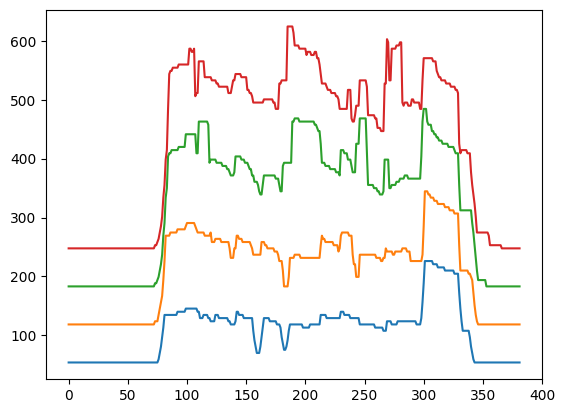

In [430]:
# Original
original_audio = promonet.load.audio('original.wav')
original_formants = promonet.formants.from_audio(
    original_audio,
    promonet.SAMPLE_RATE,
    features='stft',
    decoder='viterbi')
print(original_formants.mean(dim=1))
for formant in original_formants:
    plt.plot(formant)
ipd.Audio(original_audio, rate=promonet.SAMPLE_RATE)

tensor([101.1412, 205.5660, 305.9885, 399.4776])


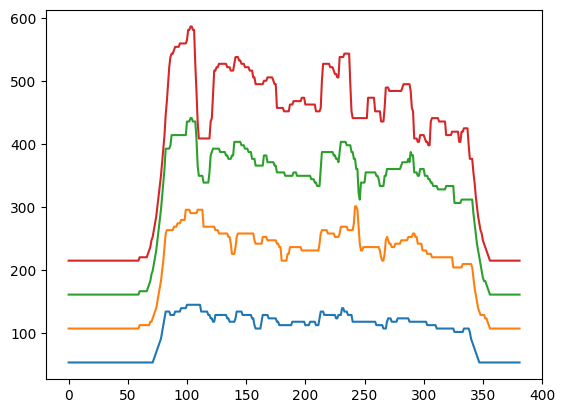

In [320]:
# Down
down_audio = promonet.load.audio('formant-071.wav')
down_formants = promonet.formants.from_audio(
    down_audio,
    promonet.SAMPLE_RATE,
    features='stft',
    decoder='viterbi')
print(down_formants.mean(dim=1))
for formant in down_formants:
    plt.plot(formant)
ipd.Audio(down_audio, rate=promonet.SAMPLE_RATE)

tensor([131.0031, 235.5687, 448.0823, 564.6547])


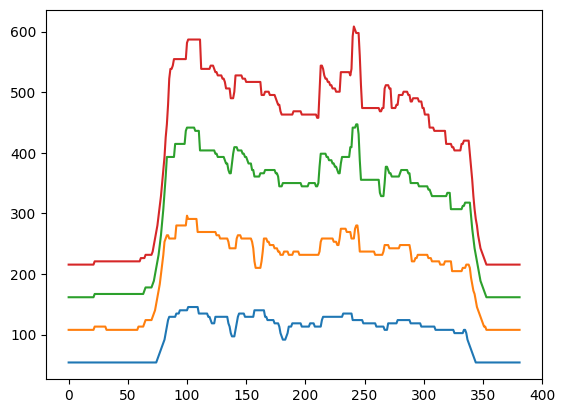

In [321]:
# Up
up_audio = promonet.load.audio('formant-141.wav')
print(up_formants.mean(dim=1))
up_formants = promonet.formants.from_audio(
    up_audio,
    promonet.SAMPLE_RATE,
    features='stft',
    decoder='viterbi')
for formant in up_formants:
    plt.plot(formant)
ipd.Audio(up_audio, rate=promonet.SAMPLE_RATE)

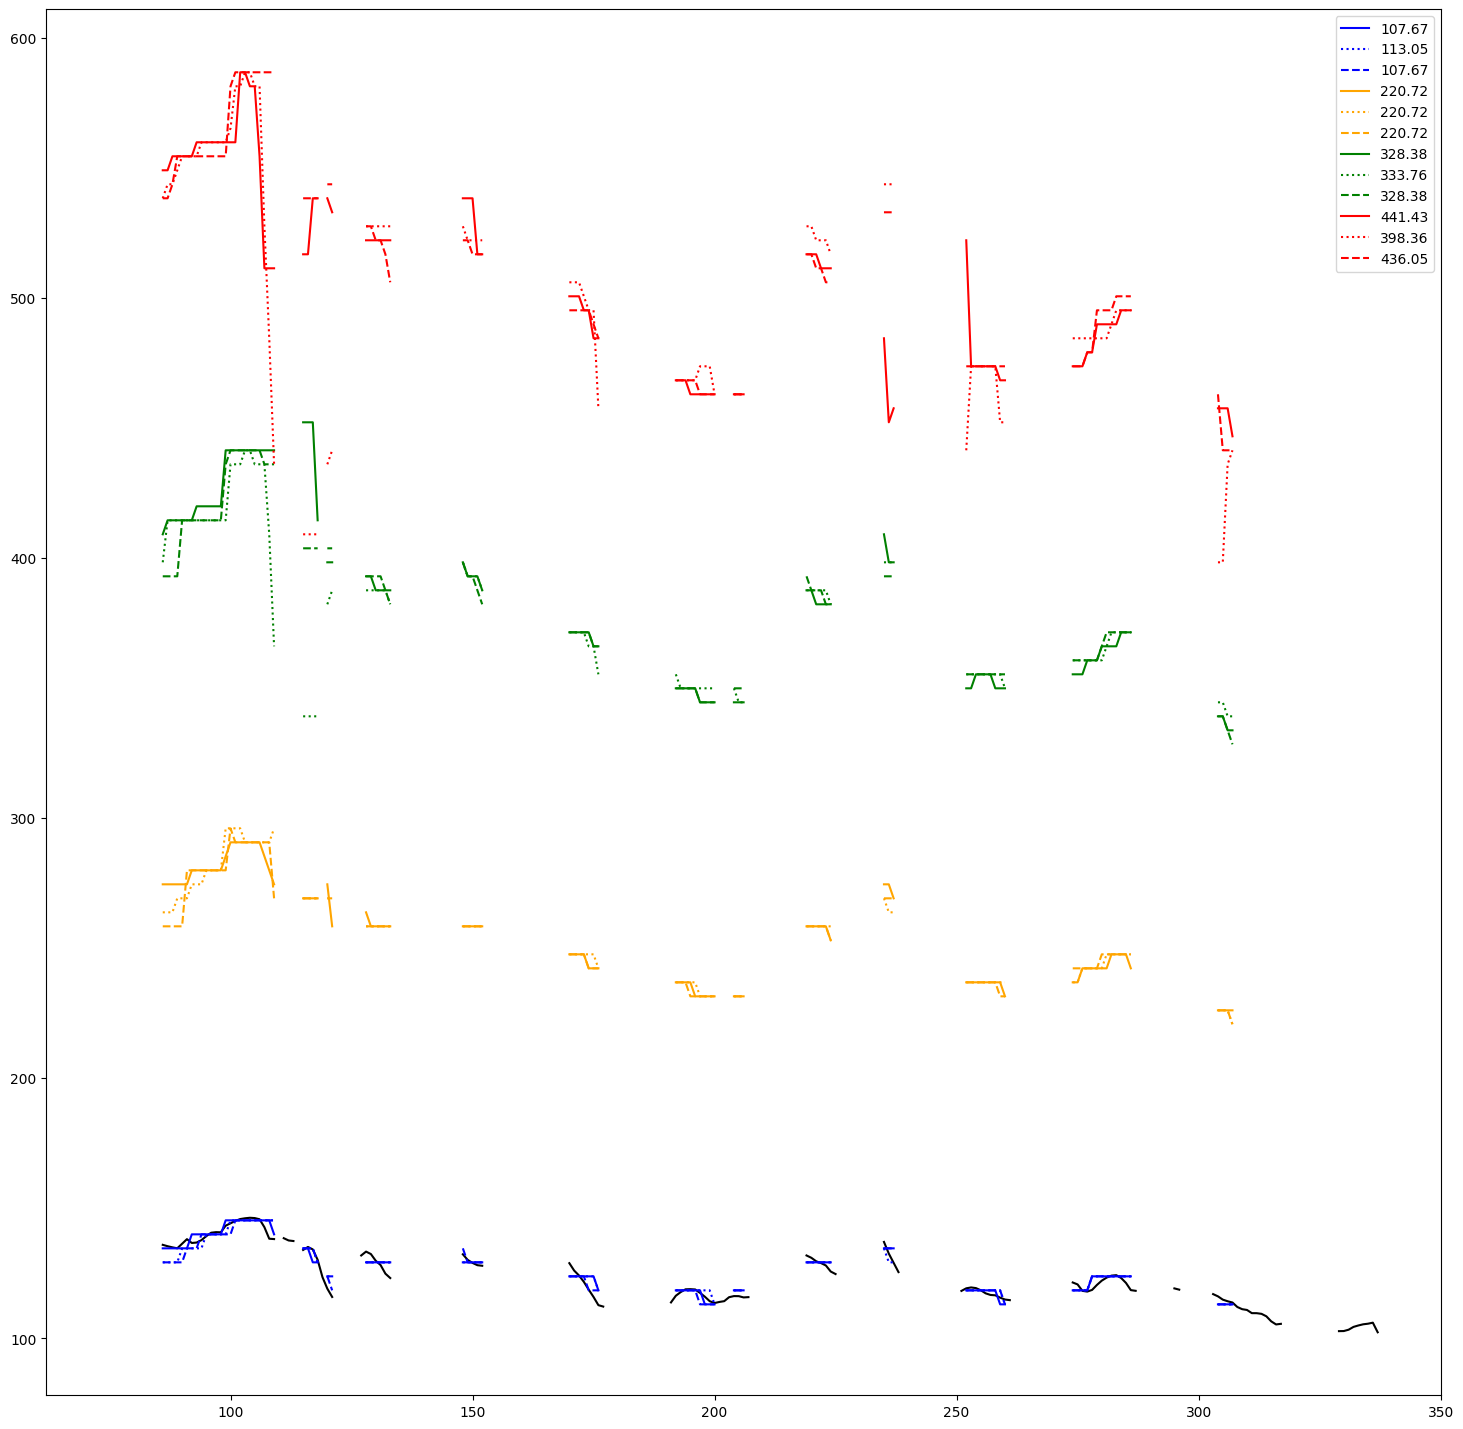

In [322]:
# Visualize all formants
colors = ['blue', 'orange', 'green', 'red']
plt.figure(figsize=(18, 18))
chunk_size = None
voiced = torch.clone(pitch)
voiced[periodicity < promonet.VOICING_THRESHOLD] = float('nan')
plt.plot(voiced[0, :chunk_size], color='black')
for color, original, down, up in zip(
    colors,
    original_formants,
    down_formants,
    up_formants
):
    original, down, up = original[None], down[None], up[None]
    original[periodicity < 2.0 * promonet.VOICING_THRESHOLD] = float('nan')
    down[periodicity < 2.0 * promonet.VOICING_THRESHOLD] = float('nan')
    up[periodicity < 2.0 * promonet.VOICING_THRESHOLD] = float('nan')
    plt.plot(
        original[0, :chunk_size],
        color=color,
        linestyle='solid',
        label=f'{torch.min(original[~torch.isnan(original)]):.02f}')
    plt.plot(
        down[0, :chunk_size],
        color=color,
        linestyle='dotted',
        label=f'{torch.min(down[~torch.isnan(down)]):.02f}')
    plt.plot(
        up[0, :chunk_size],
        color=color,
        linestyle='dashed',
        label=f'{torch.min(up[~torch.isnan(up)]):.02f}')
plt.legend()

In [299]:
print(down_formants.mean(dim=1))
print(original_formants.mean(dim=1))
print(up_formants.mean(dim=1))

tensor([116.4033, 248.3083, 355.3542, 804.2257])
tensor([139.2894, 304.3397, 418.8828, 570.2916])
tensor([131.0031, 235.5687, 448.0823, 564.6547])
